In [71]:
# Importing necessary libraries
%matplitlib inline

import pandas as pd
import numpy as np
from scipy.stats import norm
from math import sqrt
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import norm

In [110]:
test_data=pd.read_csv('c:/Users/USER/Desktop/abtest/ab2_repo/Test_Group_Data.csv')
control_data=pd.read_csv('c:/Users/USER/Desktop/abtest/ab2_repo/Control_Group_Data.csv')

In [108]:
test_data.head()

,User_ID,Group,Sessions,Time_Spent_Minutes,Actions_Per_Session,Purchases,Average_Purchase_Value,Age,Gender
0,10001,Test,8,131.665394,15.011699,2,10.236533,40,Male
1,10002,Test,6,98.624825,18.789417,2,17.061626,45,Male
2,10003,Test,3,123.336965,22.588025,3,3.904987,18,Male
3,10004,Test,7,204.462366,10.377211,2,7.077072,45,Male
4,10005,Test,3,143.998878,12.994712,2,7.021393,35,Female


In [112]:
# gender별로는 차이가 없어 보임.
print(control_data.groupby('Gender')['Average_Purchase_Value'].mean())
print(test_data.groupby('Gender')['Average_Purchase_Value'].mean())

Gender
Female     9.937022
Male      10.013968
Other     10.008932
Name: Average_Purchase_Value, dtype: float64
Gender
Female    10.536788
Male      10.446812
Other     10.781409
Name: Average_Purchase_Value, dtype: float64


In [32]:
# Calculate Engagement and Monetization Scores for control
control_data['Engagement_Score'] = (control_data['Sessions'] + control_data['Time_Spent_Minutes'] + 
                                    control_data['Actions_Per_Session']) / 3
control_data['Monetization_Score'] = (control_data['Purchases'] * control_data['Average_Purchase_Value']) / 10

# Calculate Engagement and Monetization Scores for test
test_data['Engagement_Score'] = (test_data['Sessions'] + test_data['Time_Spent_Minutes'] + 
                                 test_data['Actions_Per_Session']) / 3
test_data['Monetization_Score'] = (test_data['Purchases'] * test_data['Average_Purchase_Value']) / 10

# Combine into final dataset
ab_test_data = pd.concat([control_data, test_data], ignore_index=True)

 monetization score를 임의로 10으로 나눠주는 건 좋지 못함. plot만 보는 건 상관 없는데 통계 검정에서는 결과를 왜곡시킬 수 있음.

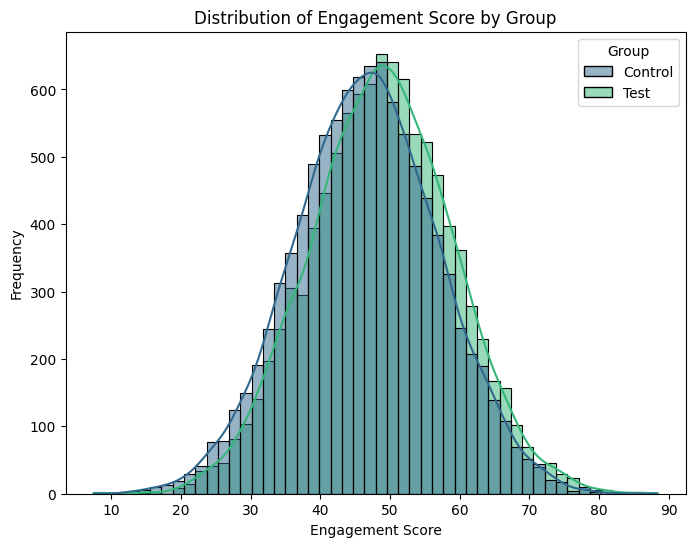

In [36]:
plt.figure(figsize=(8, 6))
sns.histplot(data=ab_test_data, x='Engagement_Score', hue='Group', kde=True, bins=50, palette='viridis')
plt.title('Distribution of Engagement Score by Group')
plt.xlabel('Engagement Score')
plt.ylabel('Frequency')
plt.show()

normal distribution을 보임.
test group에서 engagement score가 높게 나타남.

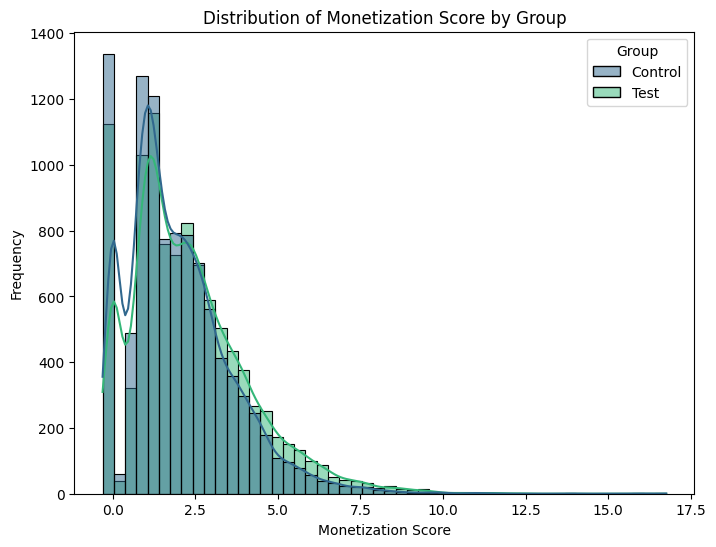

In [37]:
# Plot distribution of Monetization Score for both groups
plt.figure(figsize=(8, 6))
sns.histplot(data=ab_test_data, x='Monetization_Score', hue='Group', kde=True, bins=50, palette='viridis')
plt.title('Distribution of Monetization Score by Group')
plt.xlabel('Monetization Score')
plt.ylabel('Frequency')
plt.show()
# score가 낮은 쪽은 control group이, 높은 쪽은 test group이 많다. 이걸 해석할 여지가 많을 것이라고 본다..
# 

right-skewed distribution을 보임.
test group에서 monetization score이 높게 나타남.

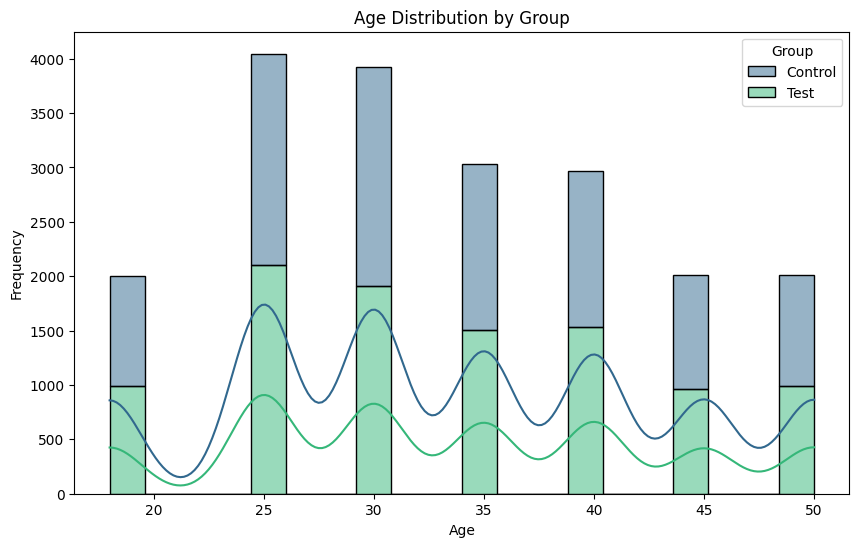

In [106]:
# Distribution of Age across Groups
plt.figure(figsize=(10, 6))
sns.histplot(data=ab_test_data, x='Age', hue='Group', multiple='stack', palette='viridis', kde=True, bins=20)
plt.title('Age Distribution by Group')
plt.ylabel('Frequency')
plt.xlabel('Age')

25~34세 이용자가 가장 많고 이외 연령대는 대체로 고르게 분포됨.

C:\Users\USER\AppData\Local\Temp\ipykernel_4684\4136919062.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=ab_test_data, x='Group', y='Sessions', palette='viridis')


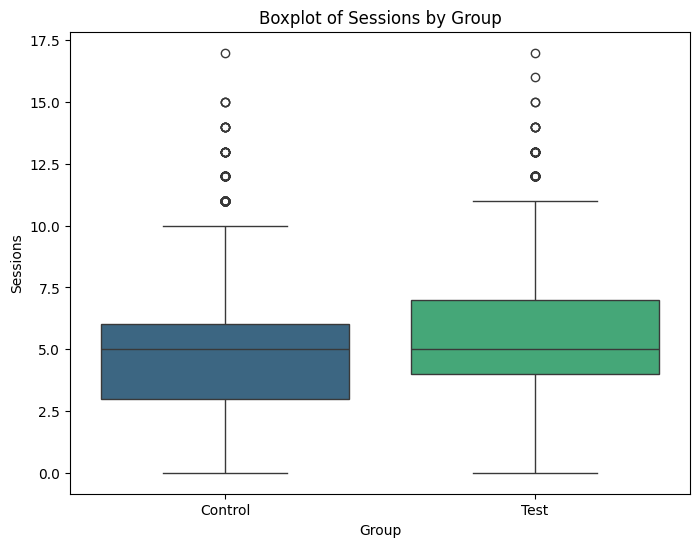

In [52]:
# Boxplot for Sessions by Group
plt.figure(figsize=(8, 6))
sns.boxplot(data=ab_test_data, x='Group', y='Sessions', palette='viridis')
plt.title('Boxplot of Sessions by Group')
plt.xlabel('Group')
plt.ylabel('Sessions')
plt.show()
## test group에서 세션도 길게 즐기네! 좋다

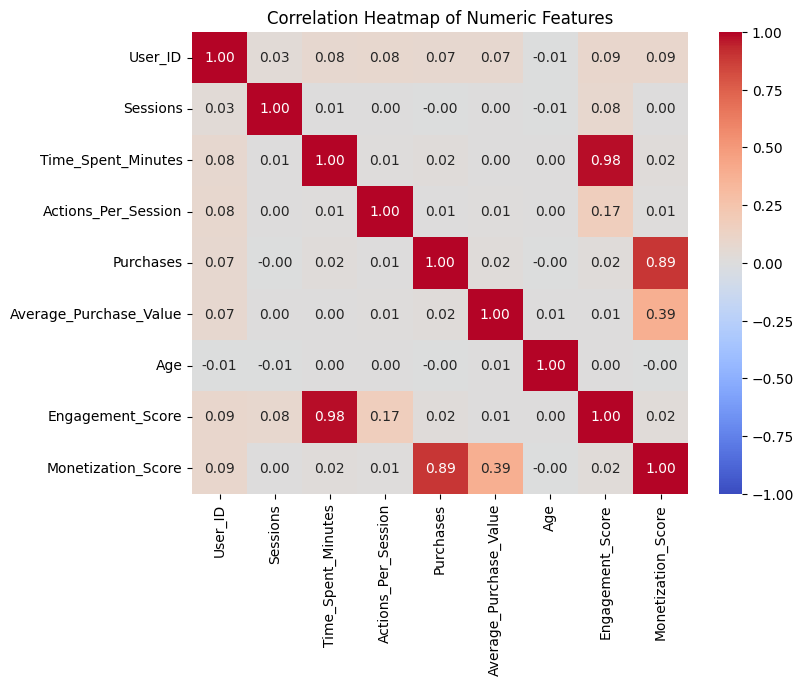

In [40]:
# Correlation heatmap for numeric features
numeric_features = ab_test_data.select_dtypes(include=[np.number])
plt.figure(figsize=(8, 6))
sns.heatmap(numeric_features.corr(), annot=True, fmt='.2f', cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation Heatmap of Numeric Features')
plt.show()

Engagement_Score = (Sessions + Time_Spent_Minutes + Actions_Per_Session) / 3
Monetization_Score = (Purchases * Average_Purchase_Value) / 10

engagement score와 monetization score는 각 score를 산출하는 데 사용한 변수들에 대해서만 상관관계가 있는 것으로 나옴.
특히 time_spent_minutes와 engagement score의 상관계수는 거의 1에 근접하는 반면, 지표 산출에 같은 가중치로 사용된 sessions와 actions_per_session의 상관관계는 낮게 산출된 것으로 보아(0.08,0.17) time_spent_minutes의 변화량이 다른 두 지표에 비해  상대적으로 크며, 따라서 engagement score 산출에 지배적인 영향을 끼침.

반면에 monetization score 산출에 사용된 두 지표인 purchases와 average_purchase_value는 0.89,0.39로 engagement score에 비해서는 어느 한 쪽의 지표에 지배적인 영향을 받는다고 볼 수는 없음.
Engagement Score는 합산 기반이라 개별 변수의 영향력이 상대적으로 분산될 수 있지만,
Monetization Score는 곱셈 기반이므로 구성 변수 간 단순 상관계수 비교만으로 전체 영향력을 판단하는 데 주의가 필요하다.

결론: engagement score는 사실상 time_spent_minutes 지표와 동일하다고 볼 수 있다. 현재 데이터셋의 한계로 인한 것이겠지만, 여러 지표를 pooling함으로써 의미 있는 지표를 만드려면 상관계수가 경험적으로 0.5~0.8사이의 지표들을 선별해서 사용해야 한다.


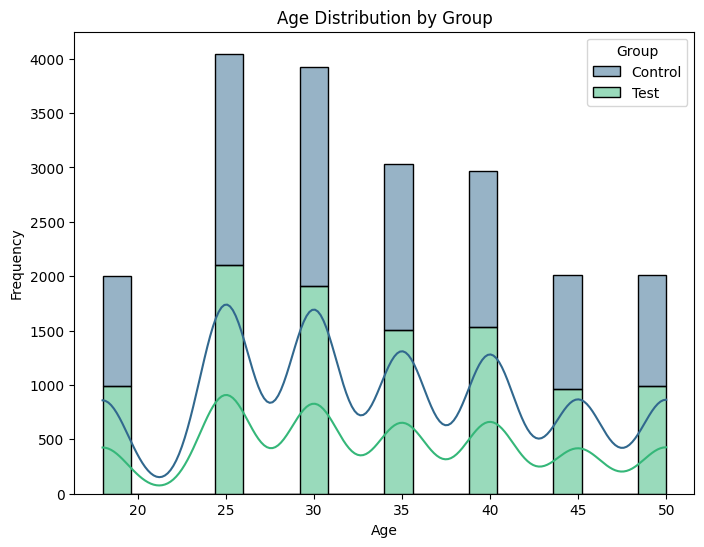

In [67]:
# Distribution of Age across Groups
plt.figure(figsize=(8, 6))
sns.histplot(data=ab_test_data, x='Age', hue='Group', multiple='stack', palette='viridis', kde=True, bins=20)
plt.title('Age Distribution by Group')
plt.ylabel('Frequency');
plt.xlabel('Age')

게임 이용자의 나이에 따른 분포를 보여주는 histogram

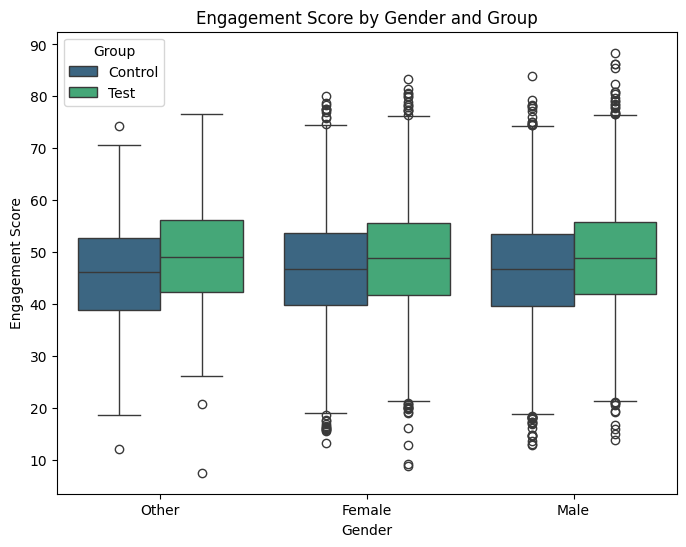

In [45]:
## Analyzing Monetization by gender
plt.figure(figsize=(8, 6))
sns.boxplot(data=ab_test_data, x='Gender', y='Engagement_Score', hue='Group', palette='viridis')
plt.title('Engagement Score by Gender and Group')
plt.xlabel('Gender')
plt.ylabel('Engagement Score')
plt.legend(title='Group')
plt.show()

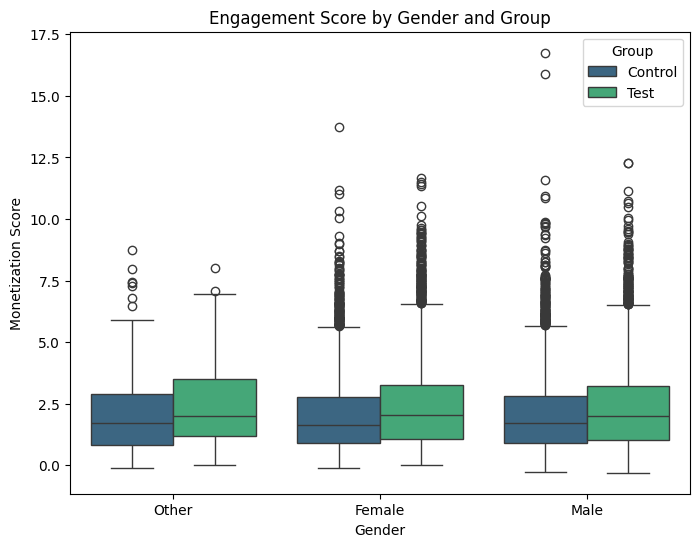

In [50]:
# Analyzing Monetization by gender
plt.figure(figsize=(8, 6))
sns.boxplot(data=ab_test_data, x='Gender', y='Monetization_Score', hue='Group', palette='viridis')
plt.title('Monetization Score by Gender and Group')
plt.xlabel('Gender')
plt.ylabel('Monetization Score')
plt.legend(title='Group')
plt.show()

 - engagement score와 monetization score 모두 각 성별에서 test 그룹에서 높은 수치를 보인다.
 - 성별에 의한 차이는 크지 않은 것으로 보인다. 다만 'other'성별은 outlier가 작은 것이 특징.

### statistical analysis
#### one-tailed t-test

In [103]:
# Recalculating means and standard deviations using the dataset from EDA
mean_control_monetization = ab_test_data[ab_test_data['Group'] == 'Control']['Monetization_Score'].mean()
mean_test_monetization = ab_test_data[ab_test_data['Group'] == 'Test']['Monetization_Score'].mean()
mean_control_engagement = ab_test_data[ab_test_data['Group'] == 'Control']['Engagement_Score'].mean()
mean_test_engagement = ab_test_data[ab_test_data['Group'] == 'Test']['Engagement_Score'].mean()

## standard deviation for each group
std_control_mon=np.sqrt(np.mean((ab_test_data[ab_test_data['Group'] == 'Control']['Monetization_Score']-mean_control_monetization)**2))
std_test_mon=np.sqrt(np.mean((ab_test_data[ab_test_data['Group'] == 'Test']['Monetization_Score']-mean_test_monetization)**2))
std_control_eng=np.sqrt(np.mean((ab_test_data[ab_test_data['Group'] == 'Control']['Engagement_Score']-mean_control_engagement)**2))
std_test_eng=np.sqrt(np.mean((ab_test_data[ab_test_data['Group'] == 'Test']['Engagement_Score']-mean_test_engagement)**2))

##
n1=10000 # sample size of control dataset
n2=10000 # sample size of test dataset

## z-statistic for monetization score
z_score_monetization=(mean_test_monetization-mean_control_monetization)/np.sqrt(std_control_mon**2/n1+std_test_mon**2/n2)
p_value_monetization = 1 - norm.cdf(z_score_monetization)  # One-tailed test
print(z_score_monetization,p_value_monetization)
## z-statistic for engagement score
z_score_engagement=(mean_test_engagement-mean_control_engagement)/np.sqrt(std_control_eng**2/n1+std_test_eng**2/n2)
p_value_engagement = 1 - norm.cdf(z_score_engagement)  # One-tailed test
print(z_score_engagement,p_value_engagement)

14.041473515965125 0.0
14.772509470206339 0.0


기존 포스팅에서는 이표본 t-test에서 population variance, population standard deviation의 개념을 혼동하고 있어 알맞은 sample variance, sample standard deviation으로 수정함.

In [83]:
# Summarizing results
results = {
    "Metric": ["Monetization Score", "Engagement Score"],
    "Control Mean": [mean_control_monetization, mean_control_engagement],
    "Test Mean": [mean_test_monetization, mean_test_engagement],
    "Z-Score": [z_score_monetization, z_score_engagement],
    "P-Value": [p_value_monetization, p_value_engagement],
    "Significant (α=0.05)": [p_value_monetization < 0.05, p_value_engagement < 0.05],
     "Conclusion": [
        "Reject Null Hypothesis" if p_value_monetization < 0.05 else "Fail to Reject Null Hypothesis",
        "Reject Null Hypothesis" if p_value_engagement < 0.05 else "Fail to Reject Null Hypothesis"
    ]
}

# Displaying the results to the user
results_df = pd.DataFrame(results)

results_df

,Metric,Control Mean,Test Mean,Z-Score,P-Value,Significant (α=0.05),Conclusion
0,Monetization Score,1.982230,2.315355,4.601183,0.000002,True,Reject Null Hypothesis
1,Engagement Score,46.646436,48.794120,39.919771,0.000000,True,Reject Null Hypothesis


One-tailed t-test 결과, monetization과 engagement 모두 control dataset과 test dataset 간의 차이가 극히 유의하다고 판단됨.
이는 새로운 시도가 유저들의 게임 몰입도를 높이고, 결제 활동의 유의미한 증가로 이어진다는 것을 의미한다고 볼 수 있음.